## Visualize the Environment Model

Evaluate and visualize the performance of the environment model by seeing it visualize future states while a A2C agent plays the game.

First start off with some imports.

In [1]:
import numpy as np
import tensorflow as tf
from env_model import make_env, create_env_model
from common.multiprocessing_env import SubprocVecEnv
from pacman_util import num_pixels, mode_rewards, pix_to_target, rewards_to_target
from a2c import get_actor_critic, CnnPolicy
from i2a import convert_target_to_real
from common.minipacman import MiniPacman  

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

Next create the environments we will use.

In [3]:
nenvs = 16
nsteps = 5
envs = [make_env() for i in range(nenvs)]
envs = SubprocVecEnv(envs)

ob_space = envs.observation_space.shape
ac_space = envs.action_space
num_actions = envs.action_space.n

Finally, go ahead and test the environment model in minipacman. This will use the A2C agent to play the game and the environment model to predict future states and rewards. Note that you should replace the locations of my weights with the locations of your own saved weights. This will visualize the imagined and real rewards and game states from the environment model. 

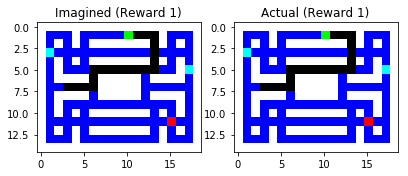

In [4]:
env = MiniPacman('regular', 1000)
done = False
states = env.reset()
num_actions = ac_space.n
nw, nh, nc = ob_space
print('observation space', ob_space)
print('number of actions', num_actions)
steps = 0

with tf.Session() as sess:
    # Load the actor
    with tf.variable_scope('actor'):
        actor_critic = get_actor_critic(sess, nenvs, nsteps, ob_space,
                ac_space, CnnPolicy, should_summary=False)
    actor_critic.load('weights/model_100000.ckpt')
    
    # Load the critic
    with tf.variable_scope('env_model'): 
        env_model = create_env_model(ob_space, num_actions, num_pixels,
                len(mode_rewards['regular']), should_summary=False)

    save_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='env_model')
    loader = tf.train.Saver(var_list=save_vars)
    loader.restore(sess, 'weights/env_model.ckpt')
    
    while not done and steps < 20:
        steps += 1
        actions, _, _ = actor_critic.act(np.expand_dims(states, axis=0))

        onehot_actions = np.zeros((1, num_actions, nw, nh))
        onehot_actions[range(1), actions] = 1
        # Change so actions are the 'depth of the image' as tf expects
        onehot_actions = onehot_actions.transpose(0, 2, 3, 1)

        s, r = sess.run([env_model.imag_state, 
                                        env_model.imag_reward], 
                                       feed_dict={
                env_model.input_states: np.expand_dims(states, axis=0),
                env_model.input_actions: onehot_actions
            })
        
        s, r = convert_target_to_real(1, nw, nh, nc, s, r)
        
        states, reward, done, _ = env.step(actions[0])

        clear_output(True)
        plt.figure(figsize=(10,3))
        plt.subplot(131)
        plt.title("Imagined (Reward %i)" % r[0])
        plt.imshow(s[0])
        plt.subplot(132)
        
        plt.title("Actual (Reward %i)" % reward)
        plt.imshow(states)
        plt.show()
        time.sleep(0.1)
